In [30]:
!pip install yfinance

In [31]:
import yfinance as yf
import pandas as pd


In [32]:
my_portfolio = yf.Ticker("CCL") 
my_portfolio_df = my_portfolio.history(period="1y", interval = "1d")

In [33]:
my_portfolio_df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [34]:
my_portfolio_df.sample(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-19,21.000000,21.260000,20.610001,20.870001,21273500,0,0
2020-08-28,16.580000,17.340000,16.230000,17.209999,51079100,0,0
2020-09-14,17.940001,18.120001,17.540001,17.850000,25838400,0,0
2020-12-11,22.639999,22.820000,21.280001,21.320000,52517400,0,0
2021-02-16,21.160000,22.559999,20.959999,22.469999,55038100,0,0


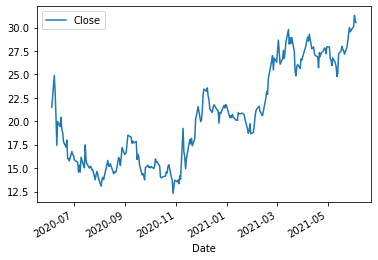

In [35]:
my_portfolio_df.plot(y = 'Close')

In [36]:
import pandas as pd
import numpy as np
%matplotlib inline

In [37]:
my_portfolio_df['decision'] = np.nan
my_portfolio_df['profit/loss'] = np.nan
my_portfolio_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,decision,profit/loss
Date,,,,,,,,,
2020-06-05,22.299999,22.940001,21.059999,21.510000,113521100,0,0,NaN,NaN
2020-06-08,24.570000,25.280001,23.410000,24.910000,107262900,0,0,NaN,NaN
2020-06-09,23.879999,23.900000,21.930000,23.040001,72547400,0,0,NaN,NaN
2020-06-10,22.200001,22.469999,19.500000,20.590000,82883100,0,0,NaN,NaN
2020-06-11,17.290001,18.990000,16.750000,17.440001,79106600,0,0,NaN,NaN


In [38]:
previous_price = 0

In [39]:
buy = []
sell = []

for index, row in my_portfolio_df.iterrows():

    if previous_price == 0:
        my_portfolio_df.loc[index, "decision"] = "buy"
        buy.append(row["Close"])
        my_portfolio_df.loc[index, "profit/loss"] = 0
    elif row["Close"] < previous_price:
        my_portfolio_df.loc[index, "decision"] = "buy"
        buy.append(row["Close"])
        my_portfolio_df.loc[index, "profit/loss"] = 0
    elif row["Close"] > previous_price:
        my_portfolio_df.loc[index, "decision"] = "sell"
        sell.append(row["Close"])
        my_portfolio_df.loc[index, "profit/loss"] = sell[-1] - buy[-1]
    else:
        my_portfolio_df.loc[index, "decision"] = "hold"

    previous_price = row["Close"]
    

In [40]:
my_portfolio_df['profit/loss'].sum()

154.61999130249023

In [41]:
my_portfolio_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,decision,profit/loss
Date,,,,,,,,,
2020-06-05,22.299999,22.940001,21.059999,21.510000,113521100,0,0,buy,0.0
2020-06-08,24.570000,25.280001,23.410000,24.910000,107262900,0,0,sell,3.4
2020-06-09,23.879999,23.900000,21.930000,23.040001,72547400,0,0,buy,0.0
2020-06-10,22.200001,22.469999,19.500000,20.590000,82883100,0,0,buy,0.0
2020-06-11,17.290001,18.990000,16.750000,17.440001,79106600,0,0,buy,0.0


In [42]:
initial_capital = 100000

# Set share size
share_size = 1000

# Calculate the total profit/loss for 500 share size orders
total_profit_loss = round(my_portfolio_df["profit/loss"].sum() * share_size, 2)

# Calculate the return on investment
roi = round((total_profit_loss / initial_capital) * 100, 2)

# Print the profit/loss and ROI metrics
print(
    f"The total profit/loss of the trading strategy is ${total_profit_loss}, "
    f"resulting in a return on investment of {roi}%"
)

The total profit/loss of the trading strategy is $154619.99, resulting in a return on investment of 154.62%


Random Forest

In [43]:
forest_df = my_portfolio_df.copy()

In [44]:
forest_df.drop(columns = ['Open', 'High', 'Low', 'Dividends','Stock Splits', 'profit/loss', 'Volume'], inplace = True)


In [45]:
forest_df.head()

,Close,decision
Date,,
2020-06-05,21.510000,buy
2020-06-08,24.910000,sell
2020-06-09,23.040001,buy
2020-06-10,20.590000,buy
2020-06-11,17.440001,buy


In [46]:
forest_df.head()

,Close,decision
Date,,
2020-06-05,21.510000,buy
2020-06-08,24.910000,sell
2020-06-09,23.040001,buy
2020-06-10,20.590000,buy
2020-06-11,17.440001,buy



Test Code (Random Forest Test)


In [47]:
test_df = my_portfolio_df.copy()
test_df.drop(columns = ['Open','High', 'Low'], inplace = True)
test_df['daily_return'] = test_df['Close'].dropna().pct_change()

In [48]:
short_window = 1
long_window = 10
###Closing Prices 

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
test_df['fast_close'] = test_df['Close'].ewm(halflife=short_window).mean()
test_df['slow_close'] = test_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
test_df['crossover_long'] = np.where(test_df['fast_close'] > test_df['slow_close'], 1.0, 0.0)
test_df['crossover_short'] = np.where(test_df['fast_close'] < test_df['slow_close'], -1.0, 0.0)
test_df['crossover_signal'] = test_df['crossover_long'] + test_df['crossover_short']


###Daily Return
# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
test_df['fast_vol'] = test_df['daily_return'].ewm(halflife=short_window).std()
test_df['slow_vol'] = test_df['daily_return'].ewm(halflife=long_window).std()

# Construct a crossover trading signal
test_df['vol_trend_long'] = np.where(test_df['fast_vol'] < test_df['slow_vol'], 1.0, 0.0)
test_df['vol_trend_short'] = np.where(test_df['fast_vol'] > test_df['slow_vol'], -1.0, 0.0) 
test_df['vol_trend_signal'] = test_df['vol_trend_long'] + test_df['vol_trend_short']

###BollingerBands
bollinger_window = 20

# Calculate rolling mean and standard deviation
test_df['bollinger_mid_band'] = test_df['Close'].rolling(window=bollinger_window).mean()
test_df['bollinger_std'] = test_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
test_df['bollinger_upper_band']  = test_df['bollinger_mid_band'] + (test_df['bollinger_std'] * 1)
test_df['bollinger_lower_band']  = test_df['bollinger_mid_band'] - (test_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
test_df['bollinger_long'] = np.where(test_df['Close'] < test_df['bollinger_lower_band'], 1.0, 0.0)
test_df['bollinger_short'] = np.where(test_df['Close'] > test_df['bollinger_upper_band'], -1.0, 0.0)
test_df['bollinger_signal'] = test_df['bollinger_long'] + test_df['bollinger_short']

test_df.head()

,Close,Volume,Dividends,Stock Splits,decision,profit/loss,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-05,21.510000,113521100,0,0,buy,0.0,NaN,21.510000,21.510000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-06-08,24.910000,107262900,0,0,sell,3.4,0.158066,23.776667,23.268894,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-06-09,23.040001,72547400,0,0,buy,0.0,-0.075070,23.355715,23.187251,1.0,0.0,1.0,0.164852,0.164852,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-06-10,20.590000,82883100,0,0,buy,0.0,-0.106337,21.880667,22.468952,0.0,-1.0,-1.0,0.118948,0.142288,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-06-11,17.440001,79106600,0,0,buy,0.0,-0.152987,19.588710,21.319134,0.0,-1.0,-1.0,0.097723,0.134909,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [53]:
#creating new data frame for machine learning
ml_df = pd.concat([test_df['crossover_signal'], test_df['vol_trend_signal'], test_df['bollinger_signal'], test_df['daily_return']], axis=1, join = 'inner' )
ml_df.head()

,crossover_signal,vol_trend_signal,bollinger_signal,daily_return
Date,,,,
2020-06-05,0.0,0.0,0.0,NaN
2020-06-08,1.0,0.0,0.0,0.158066
2020-06-09,1.0,0.0,0.0,-0.075070
2020-06-10,-1.0,1.0,0.0,-0.106337
2020-06-11,-1.0,1.0,0.0,-0.152987


In [54]:
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

ml_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-05-28,1.0,1.0,-1.0
2021-06-01,1.0,1.0,-1.0
2021-06-02,1.0,1.0,-1.0
2021-06-03,1.0,-1.0,-1.0
2021-06-04,1.0,1.0,-1.0


In [55]:
ml_df[x_var_list] = ml_df[x_var_list].shift(1)
ml_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-05-28,1.0,1.0,-1.0
2021-06-01,1.0,1.0,-1.0
2021-06-02,1.0,1.0,-1.0
2021-06-03,1.0,1.0,-1.0
2021-06-04,1.0,-1.0,-1.0


In [56]:
ml_df.dropna(subset=x_var_list, inplace=True)
ml_df.dropna(subset=['daily_return'], inplace=True)
ml_df = ml_df.replace([np.inf, -np.inf], np.nan)
ml_df.head()

,crossover_signal,vol_trend_signal,bollinger_signal,daily_return
Date,,,,
2020-06-08,0.0,0.0,0.0,0.158066
2020-06-09,1.0,0.0,0.0,-0.075070
2020-06-10,1.0,0.0,0.0,-0.106337
2020-06-11,-1.0,1.0,0.0,-0.152987
2020-06-12,-1.0,1.0,0.0,0.145642


In [57]:
ml_df['Positive Return'] = np.where(ml_df['daily_return'] > 0, 1.0, 0.0)
ml_df

,crossover_signal,vol_trend_signal,bollinger_signal,daily_return,Positive Return
Date,,,,,
2020-06-08,0.0,0.0,0.0,0.158066,1.0
2020-06-09,1.0,0.0,0.0,-0.075070,0.0
2020-06-10,1.0,0.0,0.0,-0.106337,0.0
2020-06-11,-1.0,1.0,0.0,-0.152987,0.0
2020-06-12,-1.0,1.0,0.0,0.145642,1.0
...,...,...,...,...,...
2021-05-28,1.0,1.0,-1.0,-0.014667,0.0
2021-06-01,1.0,1.0,-1.0,0.019959,1.0
2021-06-02,1.0,1.0,-1.0,0.038474,1.0


In [59]:
training_start = ml_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2021-01-04'

# Construct testing start and end dates
testing_start =  '2021-01-05'
testing_end = ml_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2020-06-08
Training End: 2021-01-04
Testing Start: 2021-01-05
Testing End: 2021-06-04


In [63]:
x_train = ml_df[x_var_list][training_start:training_end]
y_train = ml_df['Positive Return'][training_start:training_end]

In [62]:
x_test = ml_df[x_var_list][testing_start:testing_end]
y_test = ml_df['Positive Return'][testing_start:testing_end]

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [66]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2021-01-05,1.0,1.0
2021-01-06,0.0,1.0
2021-01-07,1.0,1.0
2021-01-08,0.0,0.0
2021-01-11,0.0,1.0
...,...,...
2021-05-28,0.0,0.0
2021-06-01,1.0,0.0
2021-06-02,1.0,0.0


In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[40, 11],
       [44, 10]])

True Negatives: 40

True Postives: 10

False Negatives: 44

False Positves: 11

In [72]:
from sklearn.metrics import classification_report
target_names = ['Sell', 'Buy']
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

        Sell       0.48      0.78      0.59        51
         Buy       0.48      0.19      0.27        54

    accuracy                           0.48       105
   macro avg       0.48      0.48      0.43       105
weighted avg       0.48      0.48      0.42       105



In [ ]:
Word Clouds

SyntaxError: ignored

In [ ]:
# Creating a newsapi client
newsapi = NewsApiClient(api_key=api_key)

NameError: ignored

In [ ]:
# Initial imports
import os
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from newsapi import NewsApiClient
analyzer = SentimentIntensityAnalyzer()
%matplotlib inline

ModuleNotFoundError: ignored

In [ ]:
import numpy as np
from PIL import Image
import matplotlib as mpl
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [ ]:

# Fetching the Carnival news articles
ccl_headlines = newsapi.get_everything(q="carnival", language="en")

NameError: ignored

In [ ]:
# Creating the carnival sentiment scores DataFrame
ccl_sentiments = []

for article in ccl_headlines["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        ccl_sentiments.append({
            "text": text,
            "date": date,
            "Compound": compound,
            "Positive": pos,
            "Negative": neg,
            "Neutral": neu})
        
    except AttributeError:
        pass
    
# Creating a DataFrame
ccl_df = pd.DataFrame(ccl_sentiments)

NameError: ignored

In [ ]:
# Reordering DataFrame columns
cols = ["Compound", "Negative", "Neutral", "Positive", "text"]
ccl_df = ccl_df[cols]
ccl_df.head()

NameError: ignored

In [ ]:
# Generating the ccl word cloud

ccl_text = ccl_df["text"].str.cat()
clean_ccl_text =  tokenizer(ccl_text)
big_string = '. '.join(clean_ccl_text)
wc = WordCloud().generate(big_string)
plt.title("Carnival Cruise Word Cloud", fontsize=40, loc="center", fontweight="bold")
plt.imshow(wc)

NameError: ignored